<a href="https://colab.research.google.com/github/hangnii/DL/blob/main/photo_caption_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Photo and Caption Dataset
2. Prepare Photo Data
3. Prepare Text Data
4. Develop Deep Learning Model
5. Train With Progressive Loading (NEW)
6. Evaluate Model
7. Generate New Captions

In [2]:
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
import keras
print('keras: %s' % keras.__version__)

tensorflow: 2.7.0
keras: 2.7.0


## Flickr8K

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jan 13 12:30:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!unzip -qq '/content/drive/MyDrive/data/Flickr8k_Dataset.zip'

In [3]:
!unzip -qq '/content/drive/MyDrive/data/Flickr8k_text.zip' -d './Flickr8k_text'

In [4]:
!unzip -qq '/content/drive/MyDrive/data/glove.6B.300d.txt.zip' -d './glove'

In [5]:
!unzip -qq '/content/drive/MyDrive/data/멀티모달_Part_02.zip' -d './multimodal'

- 이미지 식별자 사전을 이미지 피쳐에 반환하는 함수

In [4]:
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np

In [7]:
# extract features from each photo in the directory
def extract_features(directory):
	# load the model
	model = VGG16()
	# re-structure the model
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
	# summarize
	print(model.summary())
	# extract features from each photo
	features = dict()
	for name in listdir(directory):
		# load an image from file
		filename = directory + '/' + name
		image = load_img(filename, target_size=(224, 224))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# get features
		feature = model.predict(image, verbose=0)
		# get image id
		image_id = name.split('.')[0]
		# store feature
		features[image_id] = feature
		print('>%s' % name)
	return features
 
# extract features from all images
directory = '/content/Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
>2992658871_ac786d37a6.jpg
>1859941832_7faf6e5fa9.jpg
>3317073508_7e13565c1b.jpg
>3368671163_0171259581.jpg
>1144288288_e5c9558b6a.jpg
>1104133405_c04a00707f.jpg
>415657941_454d370721.jpg
>3061481868_d1e00b1f2e.jpg
>3439243433_d5f3508612.jpg
>3457572788_e1fe4f6480.jpg
>2826647354_650ff5eb03.jpg
>1479513774_70c94cf9d3.jpg
>1925434818_2949a8f6d8.jpg
>524036004_6747cf909b.jpg
>1425069590_570cc7c2d8.jpg
>3517362674_0f5296de19.jpg
>523249012_a0a25f487e.jpg
>3503011427_a4ee547c77.jpg
>3017521547_f5ef8848e3.jpg
>3631671718_d712821757.jpg
>2874876837_80d178ba9b.jpg
>3420064875_0349a75d69.jpg
>444057017_f1e0fcaef7.jpg
>1359101233_16c2c150e3.jpg
>3451344589_6787bd06ef.jpg
>1286408831_05282582ed.jpg
>2199200615_85e4c2a602.jpg
>403678611_73978faed7.jpg
>1468389504_c724bdcad0.jpg
>2562463210_d0dfd545ca.jpg
>2083778090_3aecaa11cc.jpg
>469969326_4b84073286.jpg
>2944362789_aebbc22db4.jpg
>3415578043_03d33e6efd.jpg
>3333675897_0043f992d3.jpg
>2451114871_8617ae2f16.jp

In [10]:

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
filename = '/content/Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)

In [ ]:
# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping
 
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

-----

In [6]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

In [7]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [8]:
root_captioning = "/content/captions"

In [9]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flickr8k_text',\
                        'Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]

In [10]:
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)

8092
8763
32


In [11]:
# Warning, running this too soon on GDrive can sometimes not work.
# Just rerun if len(img) = 0
img = glob.glob(os.path.join(root_captioning,'Flicker8k_Dataset', '*.jpg'))

In [12]:
len(img)

8091

In [13]:
train_images_path = os.path.join(root_captioning,\
            'Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,
            'Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f) 

In [14]:
print(len(train_images))
print(len(test_images))

6000
1000


In [15]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' \
                      in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

In [16]:
len(train_descriptions)


6000

In [17]:
if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = \
    tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

96124928/96112376 [==============================] - 0s 0us/step


In [18]:
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

# Creating the Training Set

In [19]:
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image 
  # encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for 
  # the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [20]:
train_path = os.path.join(root_captioning,f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
            target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

100%|██████████| 6000/6000 [05:50<00:00, 17.11it/s]



Generating training set took: 0:05:50.91


In [21]:
test_path = os.path.join(root_captioning,f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
                target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

100%|██████████| 1000/1000 [00:55<00:00, 18.02it/s]


Generating testing set took: 0:00:55.53


In [22]:
# seperate the captions - imaga / caption
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [23]:
# 10번 이하 등장 단어 삭제
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


In [24]:
# converts index numbers to actual words to index values
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

In [25]:
max_length +=2
print(max_length)

34


In [26]:
def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') \
               if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

# Loading Glove Embeddings

In [27]:
glove_dir = os.path.join(root_captioning,'glove')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:25, 15798.87it/s]

Found 400000 word vectors.


In [28]:
embedding_dim = 300

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [29]:
embedding_matrix.shape

(1652, 300)

In [30]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [31]:
embedding_dim

300

In [32]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 300)      495600      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [33]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')


# Train the Neural Network

In [34]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [35]:
model_path = os.path.join(root_captioning,f'caption-model.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1,
                    steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_
                    
                    pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, 
                            steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


2000/2000 [==============================] - 139s 68ms/step - loss: 4.0688


  5%|▌         | 1/20 [02:18<43:59, 138.93s/it]

2000/2000 [==============================] - 136s 68ms/step - loss: 3.3637


 10%|█         | 2/20 [04:34<41:10, 137.24s/it]

2000/2000 [==============================] - 137s 68ms/step - loss: 3.1492


 15%|█▌        | 3/20 [06:51<38:48, 136.99s/it]

2000/2000 [==============================] - 135s 68ms/step - loss: 3.0182


 20%|██        | 4/20 [09:07<36:22, 136.39s/it]

2000/2000 [==============================] - 135s 68ms/step - loss: 2.9212


 25%|██▌       | 5/20 [11:22<33:59, 135.95s/it]

2000/2000 [==============================] - 135s 68ms/step - loss: 2.8447


 30%|███       | 6/20 [13:37<31:40, 135.74s/it]

2000/2000 [==============================] - 135s 68ms/step - loss: 2.7891


 35%|███▌      | 7/20 [15:53<29:23, 135.64s/it]

2000/2000 [==============================] - 137s 68ms/step - loss: 2.7364


 40%|████      | 8/20 [18:09<27:11, 135.99s/it]

2000/2000 [==============================] - 137s 68ms/step - loss: 2.6984


 45%|████▌     | 9/20 [20:26<24:58, 136.22s/it]

2000/2000 [==============================] - 137s 68ms/step - loss: 2.6629


 50%|█████     | 10/20 [22:43<22:43, 136.38s/it]

2000/2000 [==============================] - 139s 70ms/step - loss: 2.6312


 55%|█████▌    | 11/20 [25:02<20:35, 137.29s/it]

2000/2000 [==============================] - 139s 69ms/step - loss: 2.6036


 60%|██████    | 12/20 [27:21<18:22, 137.79s/it]

2000/2000 [==============================] - 139s 70ms/step - loss: 2.5802


 65%|██████▌   | 13/20 [29:40<16:07, 138.28s/it]

2000/2000 [==============================] - 140s 70ms/step - loss: 2.5576


 70%|███████   | 14/20 [32:01<13:53, 138.85s/it]

2000/2000 [==============================] - 140s 70ms/step - loss: 2.5399


 75%|███████▌  | 15/20 [34:20<11:35, 139.09s/it]

2000/2000 [==============================] - 139s 70ms/step - loss: 2.5220


 80%|████████  | 16/20 [36:40<09:16, 139.13s/it]

2000/2000 [==============================] - 136s 68ms/step - loss: 2.5055


 85%|████████▌ | 17/20 [38:56<06:54, 138.21s/it]

2000/2000 [==============================] - 135s 68ms/step - loss: 2.4902


 90%|█████████ | 18/20 [41:11<04:34, 137.28s/it]

2000/2000 [==============================] - 135s 68ms/step - loss: 2.4762


 95%|█████████▌| 19/20 [43:26<02:16, 136.71s/it]

2000/2000 [==============================] - 136s 68ms/step - loss: 2.4645


100%|██████████| 20/20 [45:42<00:00, 137.11s/it]

   1/1000 [..............................] - ETA: 1:34 - loss: 2.5759


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


1000/1000 [==============================] - 72s 72ms/step - loss: 2.3054
\Training took: 0:58:55.73


In [36]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

/content/captions/Flicker8k_Dataset/2707873672_15e6b5d54b.jpg


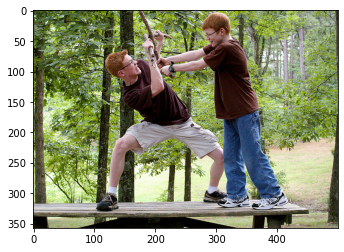

Caption: little girl in pink shirt is playing on swing
_____________________________________
/content/captions/Flicker8k_Dataset/3053743109_a2d780c0d2.jpg


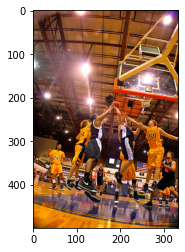

Caption: two men in basketball uniforms are fighting over basketball
_____________________________________


In [39]:
# Evaluate Performance on Test Data from Flicker8k
for z in range(2): # set higher to see more examples
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

In [38]:
encoding_test[pic].shape

(2048,)

# Evaluate Performance on My Photos

In [ ]:
# Evaluate Performance on Test Data from Flicker8k
for z in range(2): # set higher to see more examples
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

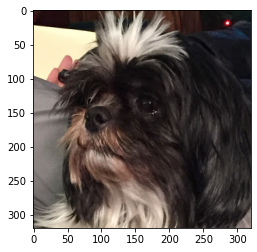

(1, 2048)
Caption: dog is running through the grass
_____________________________________


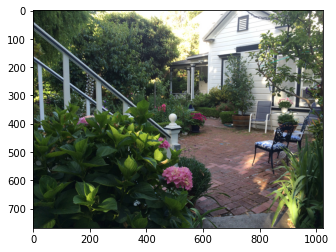

(1, 2048)
Caption: two people are walking past an umbrella on the street
_____________________________________


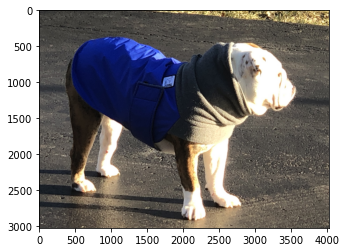

(1, 2048)
Caption: two dogs are playing with each other
_____________________________________


In [44]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

%matplotlib inline

ROOT = "https://github.com/jeffheaton/" + \
        "t81_558_deep_learning/blob/master/photos/"
urls = [
  ROOT+"annie_dog.jpg?raw=true",
  ROOT+"landscape.jpg?raw=true",
  ROOT+"hickory_coat.jpg?raw=true"
]

for url in urls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img.load()

  plt.imshow(img)
  plt.show()
  
  response = requests.get(url)

  img = encodeImage(img).reshape((1,OUTPUT_DIM))
  print(img.shape)
  print("Caption:",generateCaption(img))
  print("_____________________________________")